In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.stats import norm
from ploting import *
import seaborn as sns
%matplotlib inline

import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

## Create data

In [3]:
def generate_data(sampleSize=1000):
    
    x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, sampleSize))).T
    r_data = np.float32(np.random.normal(size=(sampleSize,1)))
    y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)
    
    return train_test_split(x_data, y_data, random_state=42)

In [4]:
X_train, X_test, y_train, y_test = generate_data()

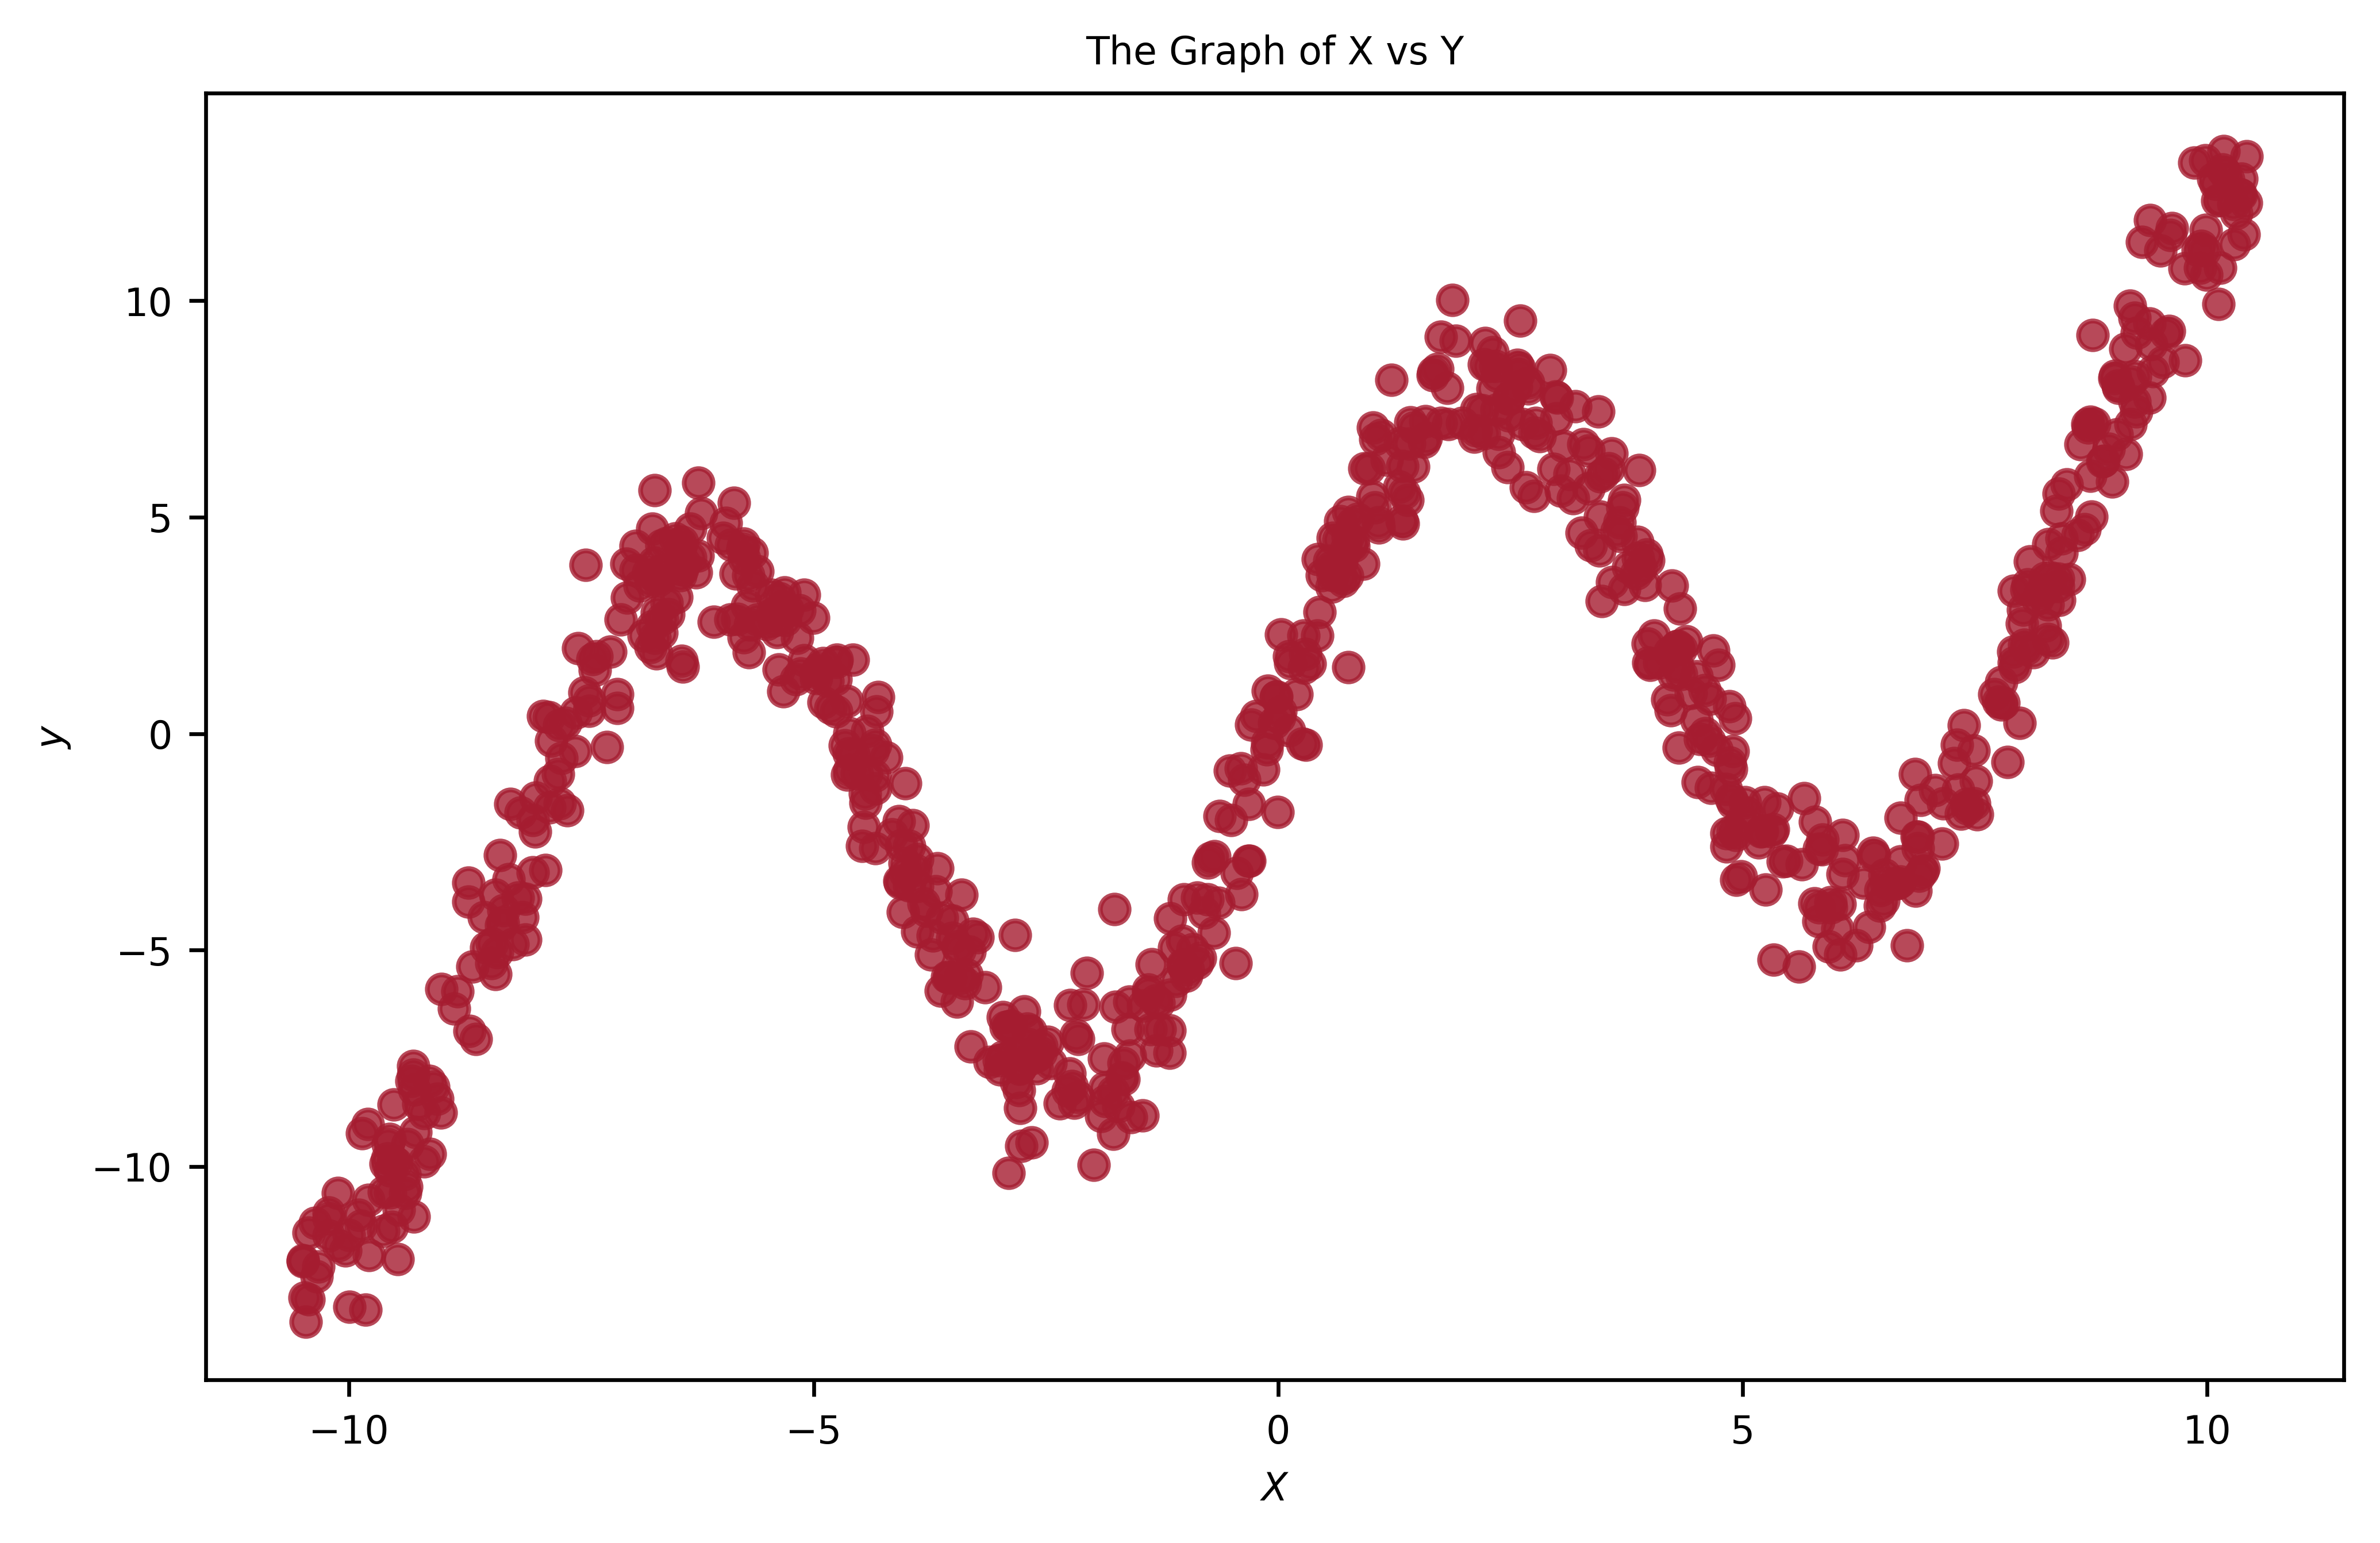

In [42]:
latexify(fig_width=8)
sns.regplot(X_train, y_train, fit_reg=False)
plt.xlabel('$X$')
plt.ylabel('$y$')
plt.title("The Graph of X vs Y");

## Define MDN

In [6]:
class MDN(torch.nn.Module):

    def __init__(self, hidden_size, num_mixtures):
        """
        In the constructor we instantiate two nn.Linear module
        """
        super(MDN, self).__init__()
        self.input_layer = torch.nn.Linear(1, hidden_size) 
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        self.pi_out = torch.nn.Sequential(torch.nn.Linear(hidden_size, num_mixtures),torch.nn.Softmax())
        self.sigma_out = torch.nn.Linear(hidden_size, num_mixtures)
        self.mu_out = torch.nn.Linear(hidden_size, num_mixtures) 
        

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        
        out = self.input_layer(x)
        out = self.tanh(out)
        out_pi = self.pi_out(out)
        out_sigma = torch.exp(self.sigma_out(out))
        out_mu = self.mu_out(out)
        
        return (out_pi, out_sigma, out_mu)

## Define Loss function

In [7]:
def gaussian_distribution(y, mu, sigma):
    
    oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalisation factor for gaussian.
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = - 0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI


def mdn_loss_function(out_pi, out_sigma, out_mu, y):
    
    result = gaussian_distribution(y, out_mu, out_sigma) * out_pi
    result = torch.sum(result, dim=1)
    result = - torch.log(result)
    
    return torch.mean(result)

## Define train function

In [8]:
def model_train(x_data, y_data, model, lrate):
    
    x_data = torch.from_numpy(x_data).float()
    y_data = torch.from_numpy(y_data).float()
    
    x_data = Variable(x_data)
    y_data = Variable(y_data)
    
    if torch.cuda.is_available():
        model = model.cuda()
        x_data = x_data.cuda()
        y_data = y_data.cuda()
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lrate)
    
    
    Epoch = []
    Loss  = []
   
    
    for epoch in range(10000):
        (out_pi, out_sigma, out_mu) = model(x_data)
        loss = mdn_loss_function(out_pi, out_sigma, out_mu, y_data)

        Epoch.append(epoch)
        Loss.append(loss.data[0])
        
        if (epoch % 500 == 0):
            print(epoch, loss.data[0])
    
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    return Epoch, Loss 

In [9]:
model = MDN(hidden_size=5, num_mixtures=20)
print(model)

MDN(
  (input_layer): Linear(in_features=1, out_features=5)
  (relu): ReLU()
  (tanh): Tanh()
  (pi_out): Sequential(
    (0): Linear(in_features=5, out_features=20)
    (1): Softmax()
  )
  (sigma_out): Linear(in_features=5, out_features=20)
  (mu_out): Linear(in_features=5, out_features=20)
)


In [10]:
epoch, loss = model_train(X_train, y_train, model, 0.01)

0 6.235991477966309
500 2.316417932510376
1000 2.0215396881103516
1500 1.850516438484192
2000 1.7158286571502686
2500 1.6134330034255981
3000 1.535304069519043
3500 1.469214916229248
4000 1.4365595579147339
4500 1.4265483617782593
5000 1.4190311431884766
5500 1.414797067642212
6000 1.4137327671051025
6500 1.4126136302947998
7000 1.4114347696304321
7500 1.4127085208892822
8000 1.4080920219421387
8500 1.3995225429534912
9000 1.4010471105575562
9500 1.417789101600647


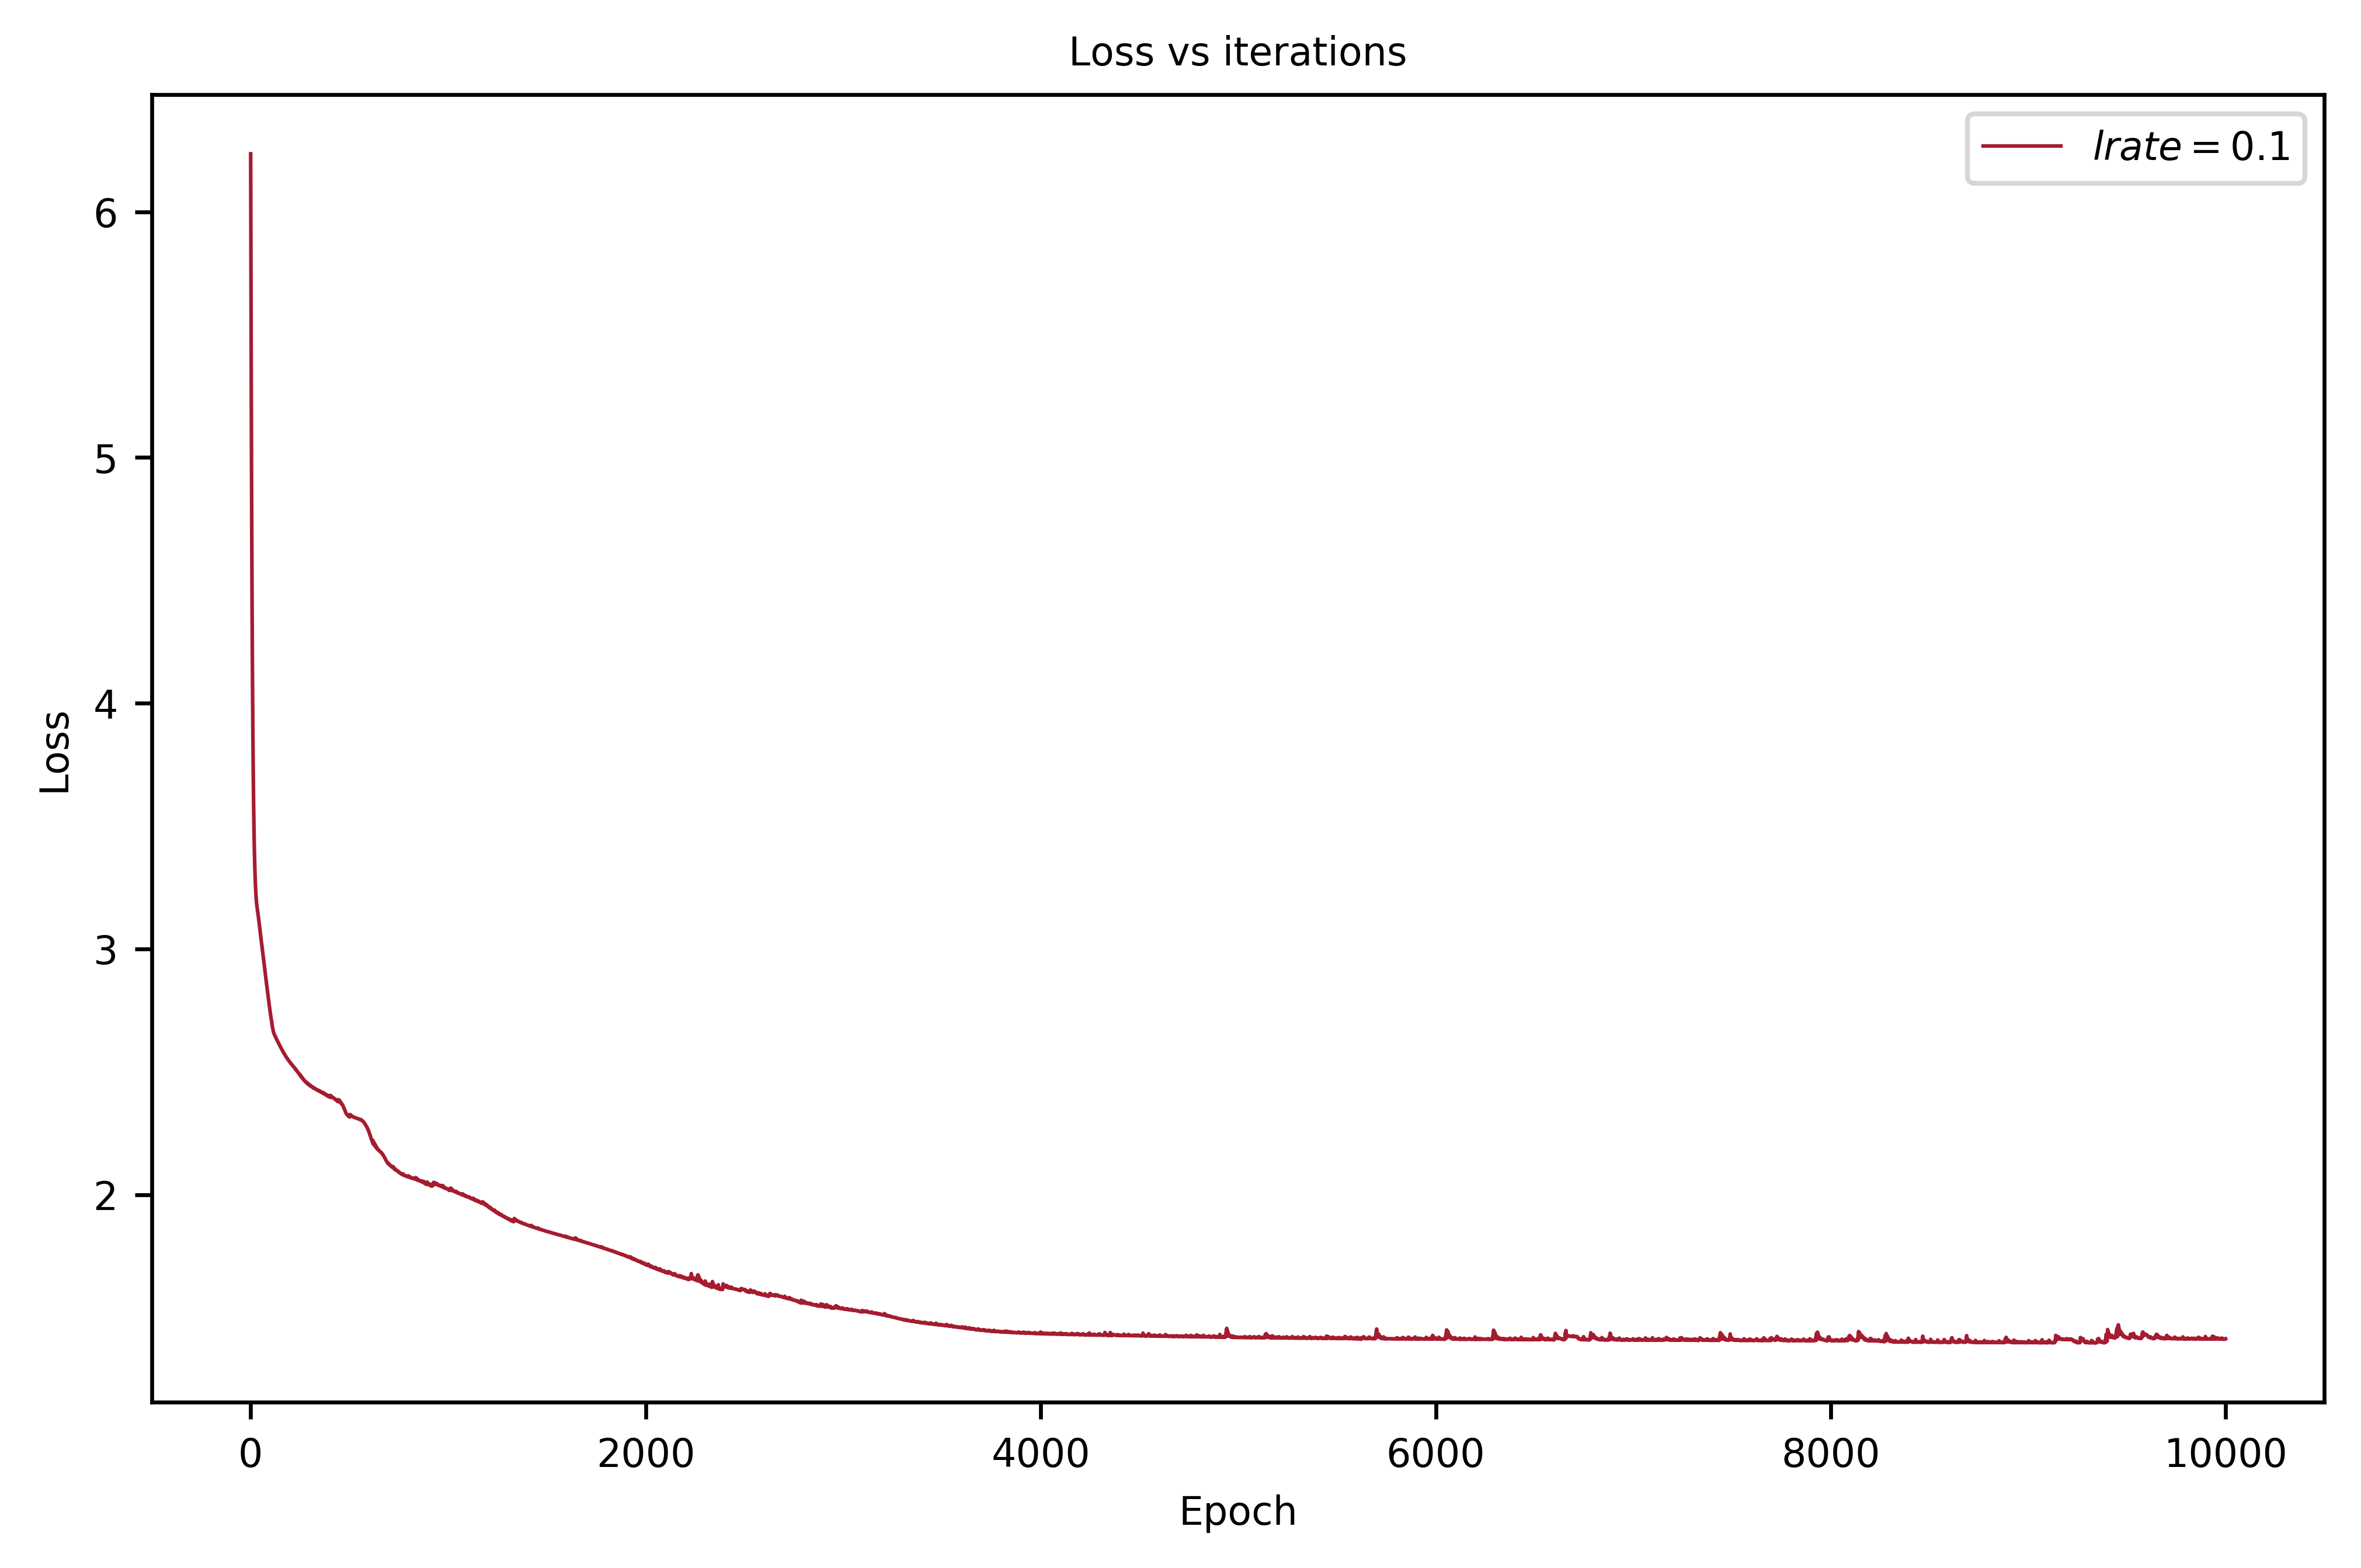

In [11]:
plt.plot(epoch, loss, label="$lrate=0.1$")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs iterations")
plt.legend();

## Define prediction

In [19]:
def predict(x_data, model):
    x_data = torch.from_numpy(x_data).float()
    x_data = Variable(x_data)
    
    if torch.cuda.is_available():
        model = model.cuda()
        x_data = x_data.cuda()
        
    (out_pi, out_sigma, out_mu) = model(x_data)
    
    if torch.cuda.is_available():
        out_pi=out_pi.cpu() # convert cuda tenso into cpu so that we can con
        out_sigma=out_sigma.cpu()
        out_mu = out_mu.cpu()
        
         
    return (out_pi.data.numpy(), out_sigma.data.numpy(), out_mu.data.numpy())

In [35]:
def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1


def generate_ensemble(x_test, out_pi, out_sigma, out_mu, M=1):
    # for each point in X, generate M=10 ensembles
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    mu = 0
    std = 0
    idx = 0
    
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
    return result

In [36]:
pi, sigma, mu = predict(X_test, model)

In [37]:
y_pred = generate_ensemble(X_test, pi, sigma, mu)

In [38]:
y_pred.shape

(250, 1)

In [39]:
y_test.shape

(250, 1)

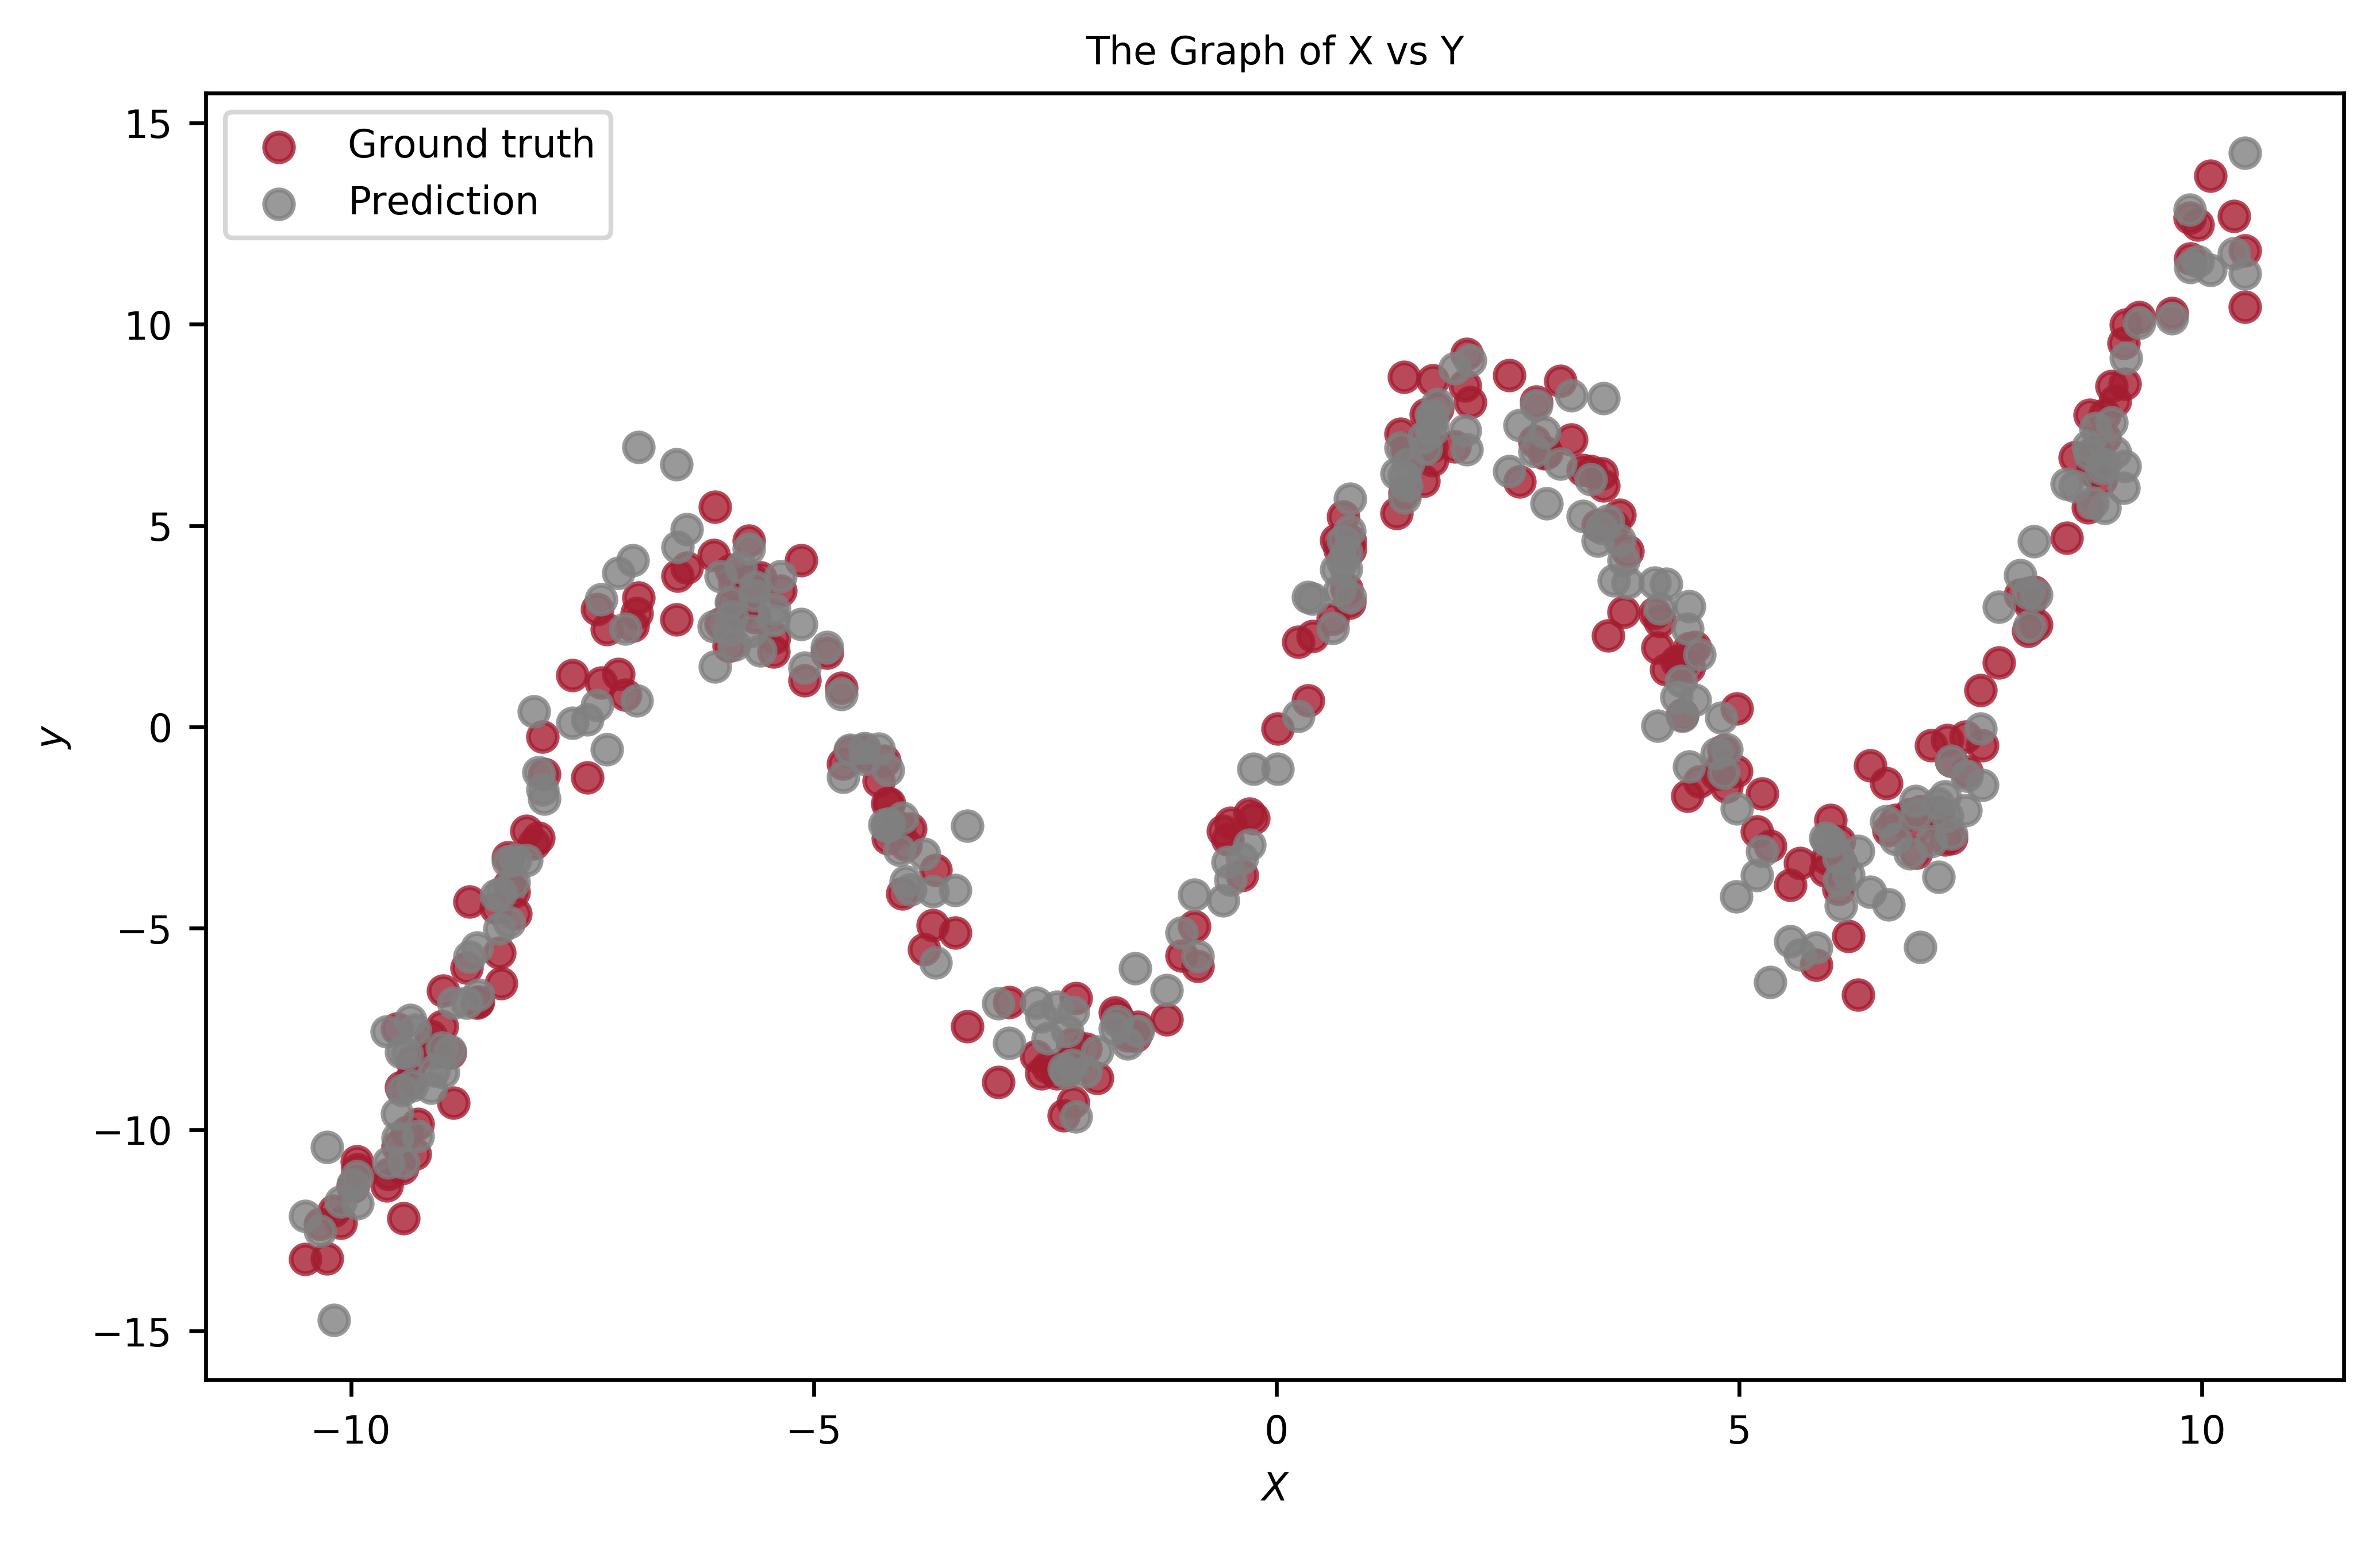

In [43]:
latexify(fig_width=8)
sns.regplot(X_test, y_test, fit_reg=False, label="Ground truth")
sns.regplot(X_test, y_pred, fit_reg=False, label="Prediction")
plt.xlabel('$X$')
plt.ylabel('$y$')
plt.legend()
plt.title("The Graph of X vs Y");